<a href="https://colab.research.google.com/github/DannyData1419/supervised-ML/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification

##Libraries | Classes | Functions

In [ ]:
!pip -q install lime
!pip -q install shap
!pip -q install dice-ml

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# classification libraries
import warnings
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# XAI libraries
import shap
import xgboost
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# counterfactual libraries
import dice_ml
from dice_ml.utils import helpers


# VERSION 2
class BinaryClassificationForTab:

    def __init__(self, x, y, classifier, label_mapping, model_desc, data_desc, experiment_num):
        """
        Initializes the evaluator with features & target, classification model, label mapping, model type, data description, and experiment number.
        """
        self.x = x                                # features
        self.y = y                                # target
        self.data_desc = data_desc                # data description (global)
        self.label_mapping = label_mapping        # feature label mapping (global)
        self.model_desc = model_desc              # model description (local)
        self.classifier = classifier              # classification model (local)
        self.experiment_num = experiment_num      # experiment number (local)
        self.clasif_report = None                 # to store classification report
        self.confusn_matrix = None                # to store confusion matrix
        self.mean_auc = None                      # to store mean AUC value
        self.estimator_num = None                 # to store estimator number
        self.idx = None                           # to store observation index


    def print_confusion_matrix(self):
        """
        Generates a confusion matrix using 5-fold cross-validation
        """
        kf = StratifiedKFold(n_splits=5)
        confusn_matrices = []

        for train_index, test_index in kf.split(self.x, self.y):
            x_train, x_test = self.x.iloc[train_index], self.x.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            self.classifier.fit(x_train, y_train)
            predictions = self.classifier.predict(x_test)

            y_test_text = [self.label_mapping[label] for label in y_test]
            pred_text = [self.label_mapping[label] for label in predictions]

            confusn_matrix_fold = confusion_matrix(y_test_text, pred_text, labels=list(self.label_mapping.values()))

            confusn_matrices.append(confusn_matrix_fold)

        self.confusn_matrix = np.mean(confusn_matrices, axis=0)

        display = metrics.ConfusionMatrixDisplay(self.confusn_matrix, display_labels=list(self.label_mapping.values()))
        display.plot()
        plt.xticks(rotation=90)
        plt.title(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}')
        plt.show()


    def print_classification_report(self):
        """
        Generates a classification report without 5-fold cross-validation
        """
        # Split the data once into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=42)

        # Fit the classifier and make predictions
        self.classifier.fit(x_train, y_train)
        predictions = self.classifier.predict(x_test)

        # Map labels to their corresponding text representations
        y_test_text = [self.label_mapping[label] for label in y_test]
        pred_text = [self.label_mapping[label] for label in predictions]

        # Generate classification report
        self.clasif_report = classification_report(y_test_text, pred_text, output_dict=False)

        # Print the results
        print(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}:\n')
        print(self.clasif_report)


    def plot_roc_curve(self):
        """
        Displays a Receiver Operating Characteristic curve plot for an ML experiment
        """
        kf = StratifiedKFold(n_splits=5)
        tprs = []
        aucs = []
        mean_false_pos_rate = np.linspace(0, 1, 100)

        for train, test in kf.split(self.x, self.y):
            x_train, x_test, y_train, y_test = self.x.iloc[train], self.x.iloc[test], self.y[train], self.y[test]
            self.classifier.fit(x_train, y_train)
            probas_ = self.classifier.predict_proba(x_test)
            false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=list(self.label_mapping.keys())[1])
            roc_auc = auc(false_pos_rate, true_pos_rate)
            aucs.append(roc_auc)
            tprs.append(np.interp(mean_false_pos_rate, false_pos_rate, true_pos_rate))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        self.mean_auc = auc(mean_false_pos_rate, mean_tpr)

        # Plot the ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(mean_false_pos_rate, mean_tpr, color='b', label=f'Mean ROC (AUC = {self.mean_auc:.3f})', lw=2, alpha=0.8)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8) # diagonal line for no-skill classifier
        plt.xlim([-0.02, 1.02])             # set limits for axes
        plt.ylim([-0.02, 1.02])
        plt.xlabel('False Positive Rate')   # set labels and title
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}')
        plt.legend(loc="lower right")       # add legend inside plot
        plt.show()                          # display plot


    def plot_feature_importance(self):
      """
      Plots a feature importance plot for a classification model
      """
      feature_imp = pd.Series(self.classifier.feature_importances_, index=self.x.columns.tolist()).sort_values(ascending=False)
      sns.barplot(x=feature_imp, y=feature_imp.index)
      plt.xlabel('Feature importance score')
      plt.ylabel('Feature name')
      plt.title(f"{self.model_desc} on {self.data_desc} feature importances, experiment #{self.experiment_num}", pad=10, size=12)
      plt.show()


    def plot_decision_tree(self):
      """
      Plots a single decision tree
      """
      plt.figure(figsize=(30, 12))
      plot_tree(self.classifier, feature_names=self.x.columns.tolist(), filled=True)
      plt.title(f"{self.model_desc} on {self.data_desc} plot, experiment #{self.experiment_num}", pad=10, size=12)
      plt.show()


    def plot_single_rf_tree(self):
      """
      Plots a single decision tree from a Random Forest ensemble
      """
      self.estimator_num = random.randint(0, len(self.classifier.estimators_)) # select a random decision tree model
      fig = plt.figure(figsize=(30, 12))
      plot_tree(self.classifier.estimators_[self.estimator_num],
                feature_names=self.x.columns.tolist(),
                class_names=self.label_mapping,
                filled=True,
                impurity=True,
                rounded=True)
      plt.title(f'{self.model_desc} on {self.data_desc} plot, experiment #{self.experiment_num}\nDecision tree #{self.estimator_num} of {len(self.classifier.estimators_)} Random Forest ensemble',
                pad=10, size=12)
      plt.show()


    # SHAP for global feature explainability
    def print_shap_for_global_explanation(self):
      """
      The shap_tree_explainer function is a comprehensive tool for training an XGBoost model on survival
      data and visualizing the feature importance using SHAP values. It handles data splitting, model
      training, and result interpretation in a single, cohesive workflow.
      """
      # model parameters
      params = {
        "eta": 0.002,                # learning rate, controls step size at each iteration
        "max_depth": 3,              # max tree depthin model
        "objective": "survival:cox", # specifies the type of model to be trained, here it's "survival," which is suitable for survival analysis
        "subsample": 0.5             # fraction of the training data to be used for training each tree
        }

      # data prep
      xgb_full = xgboost.DMatrix(self.x, label=self.y)                # converts feature matrix 'x' and labels 'y' into a DMatrix, a data structure optimized for XGBoost
      x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=8) # 80/20 train/test split
      xgb_train = xgboost.DMatrix(x_train, label=y_train)   # training set converted into DMatrix format for XGBoost
      xgb_test = xgboost.DMatrix(x_test, label=y_test)      # testing set converted into DMatrix format for XGBoost

      # train model
      model = xgboost.train(params, xgb_train,              # trains the XGBoost model with the specified parameters
                            10000,                          # the number of boosting rounds or iterations
                            evals = [(xgb_test, "test")],   # list containing the testing set, used for evaluating model performance during training
                            verbose_eval=False)             # set to False to suppress verbose output during training

      # SHAP values calc
      # shap.TreeExplainer: creates an explainer object that can calculate SHAP values for tree-based models
      # shap_values: these values represent the contribution of each feature to the model's predictions, calculated for the entire dataset 'x'
      shap_values = shap.TreeExplainer(model).shap_values(self.x)

      # shap.summary_plot: generates summary plot that visualizes SHAP values, showing impact of each feature on model output, sorted by importance
      plt.title(f'XGBoost on {self.data_desc} for global feature importance')
      shap_summary_plot = shap.summary_plot(shap_values, self.x)
      return shap_summary_plot


    def print_lime_for_local_explanation(self):
      """
      https://lime-ml.readthedocs.io/en/latest/index.html
      """
      warnings.filterwarnings("ignore", category=FutureWarning)                 # suppress specific warnings related to future deprecations
      warnings.filterwarnings("ignore", category=UserWarning)                   # suppress specific warnings related to future deprecations
      x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=8) # 80/20 train/test split
      self.idx = random.randint(0, len(x_test))                                 # select a random observation from the test set
      self.classifier.fit(x_train, y_train)
      explainer_lime = lime_tabular.LimeTabularExplainer(                       # create a lime tab explainer instance
          x_train.values,                                                       # train data values
          feature_names=self.x.columns.tolist(),                                # create feature name list
          class_names=list(self.label_mapping.values()),                        # class label mapping
          verbose=True,                                                         # print local prediction values from linear model
          mode='classification')                                                # classification task (and not regression)
      print(f'Observation #{x_test.index[self.idx]}, from a total of {len(x_test)} {self.data_desc}, for local feature importance:')
      exp = explainer_lime.explain_instance(x_test.iloc[self.idx],              # explain test data instance
                                            self.classifier.predict_proba,      # predict probabilities using classifier
                                            num_features=10)                    # limit to top 10 features
      return exp.show_in_notebook(show_table=True, show_all=False)              # display notebook and table



#Data prep

In [ ]:
# load binary dataset for classification
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

###Dataframe info

In [ ]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

###Split data into features and target

In [ ]:
x = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

###Set GLOBAL variables

In [ ]:
# set GLOBAL variables
data_desc = 'breast cancer data'
label_mapping = {0:'malignant', 1:'benign'}

#Model + evaluation

##Experiment #1 Decision Tree

In [ ]:
# set LOCAL variables per experiment
experiment_num = '1'
model_desc = 'Decision Tree'
classifier = DecisionTreeClassifier(random_state=8)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [ ]:
evaluator.print_classification_report()

Decision Tree on breast cancer data experiment #1:

              precision    recall  f1-score   support

      benign       0.94      0.94      0.94        71
   malignant       0.91      0.91      0.91        43

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



###Confusion matrix

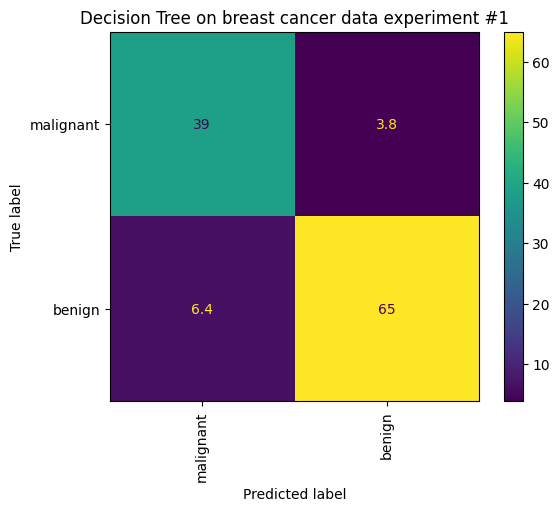

In [ ]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

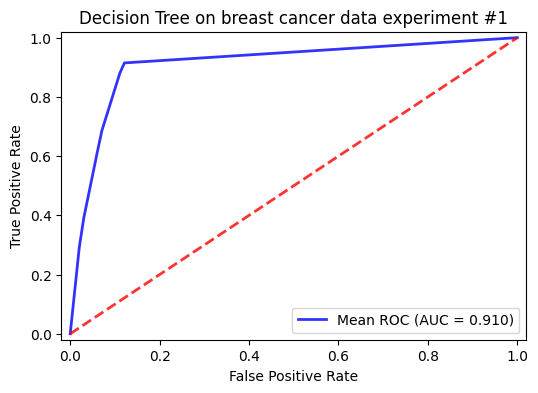

In [ ]:
evaluator.plot_roc_curve()

###Feature importance

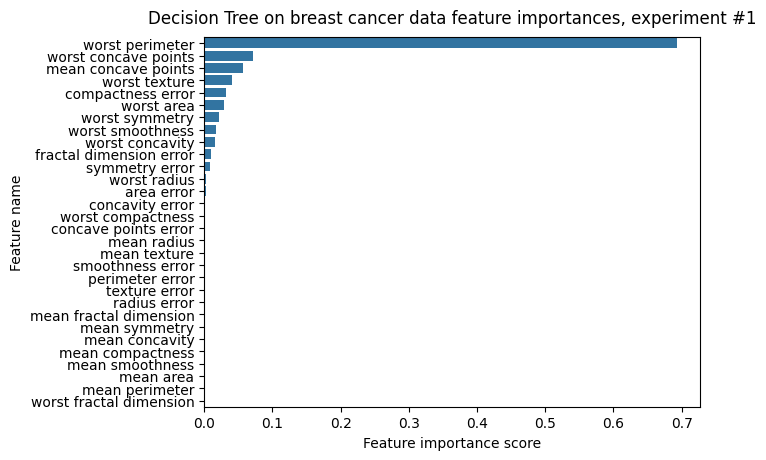

In [ ]:
evaluator.plot_feature_importance()

###Decision Tree

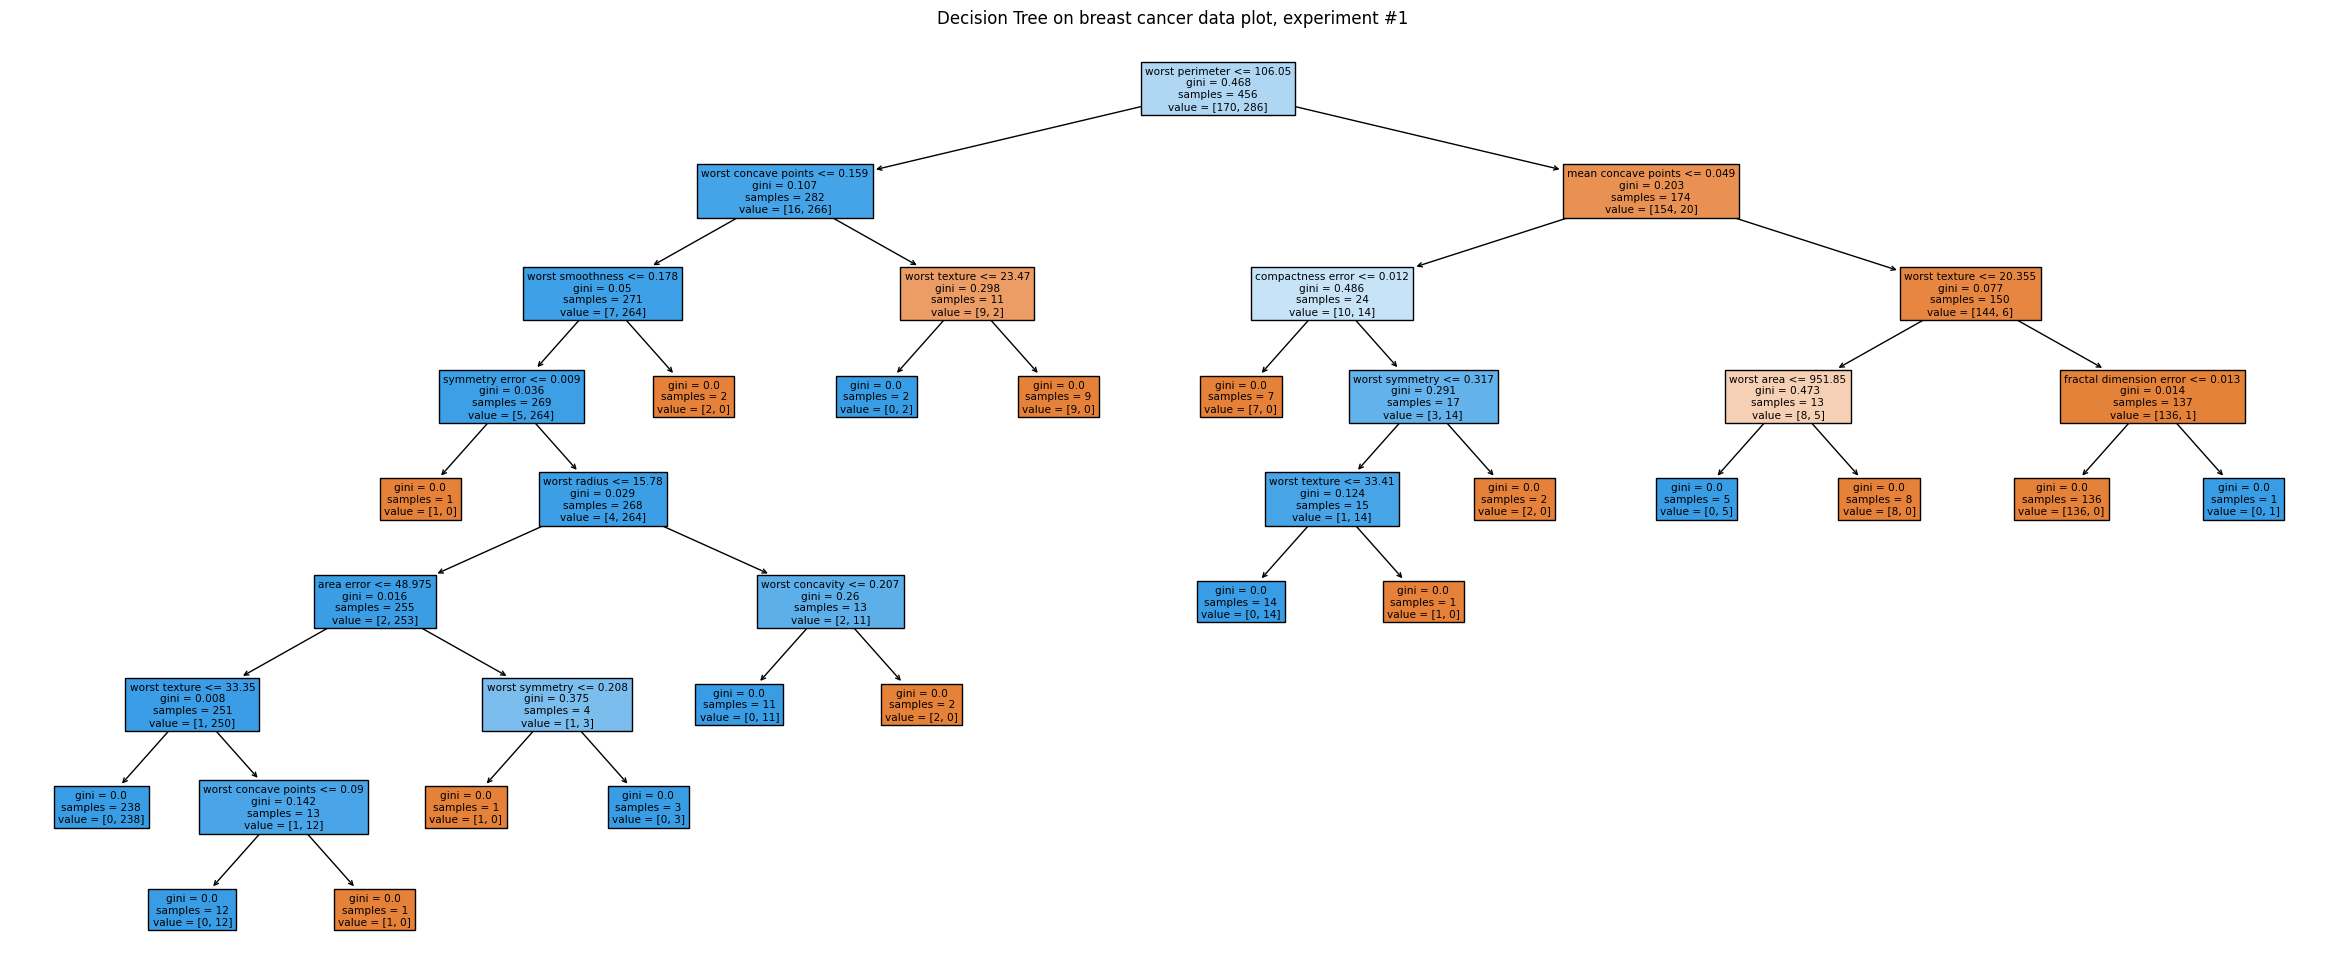

In [ ]:
evaluator.plot_decision_tree()

##Experiment #2 Random Forest

In [ ]:
# set LOCAL variables per experiment
experiment_num = '2'
model_desc = 'Random Forest'
classifier = RandomForestClassifier(random_state=8, n_estimators=500)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [ ]:
evaluator.print_classification_report()

Random Forest on breast cancer data experiment #2:

              precision    recall  f1-score   support

      benign       0.96      0.99      0.97        71
   malignant       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



###Confusion matrix

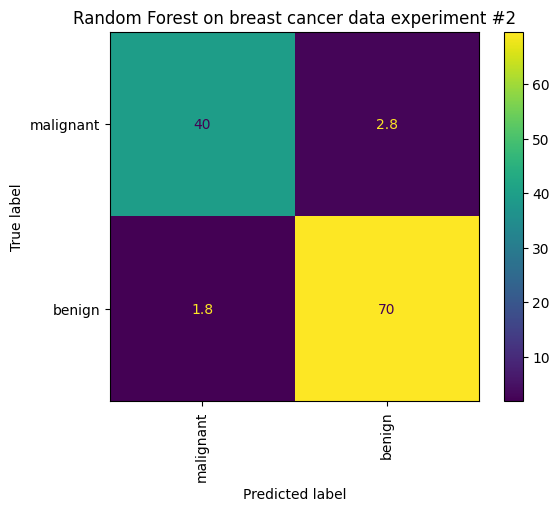

In [ ]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

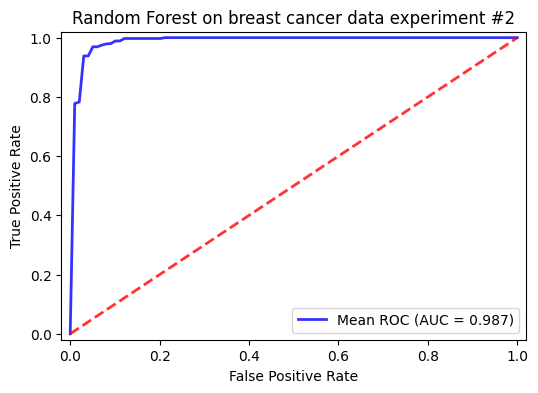

In [ ]:
evaluator.plot_roc_curve()

###Feature importance

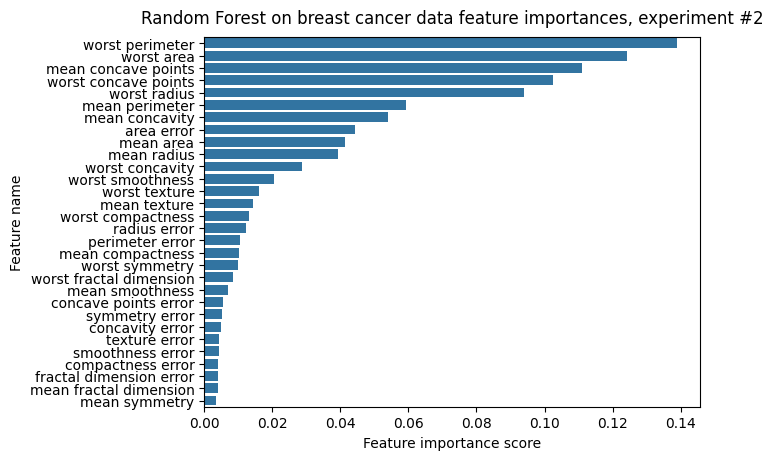

In [ ]:
evaluator.plot_feature_importance()

###Plot Decision Tree from Random Forest ensemble

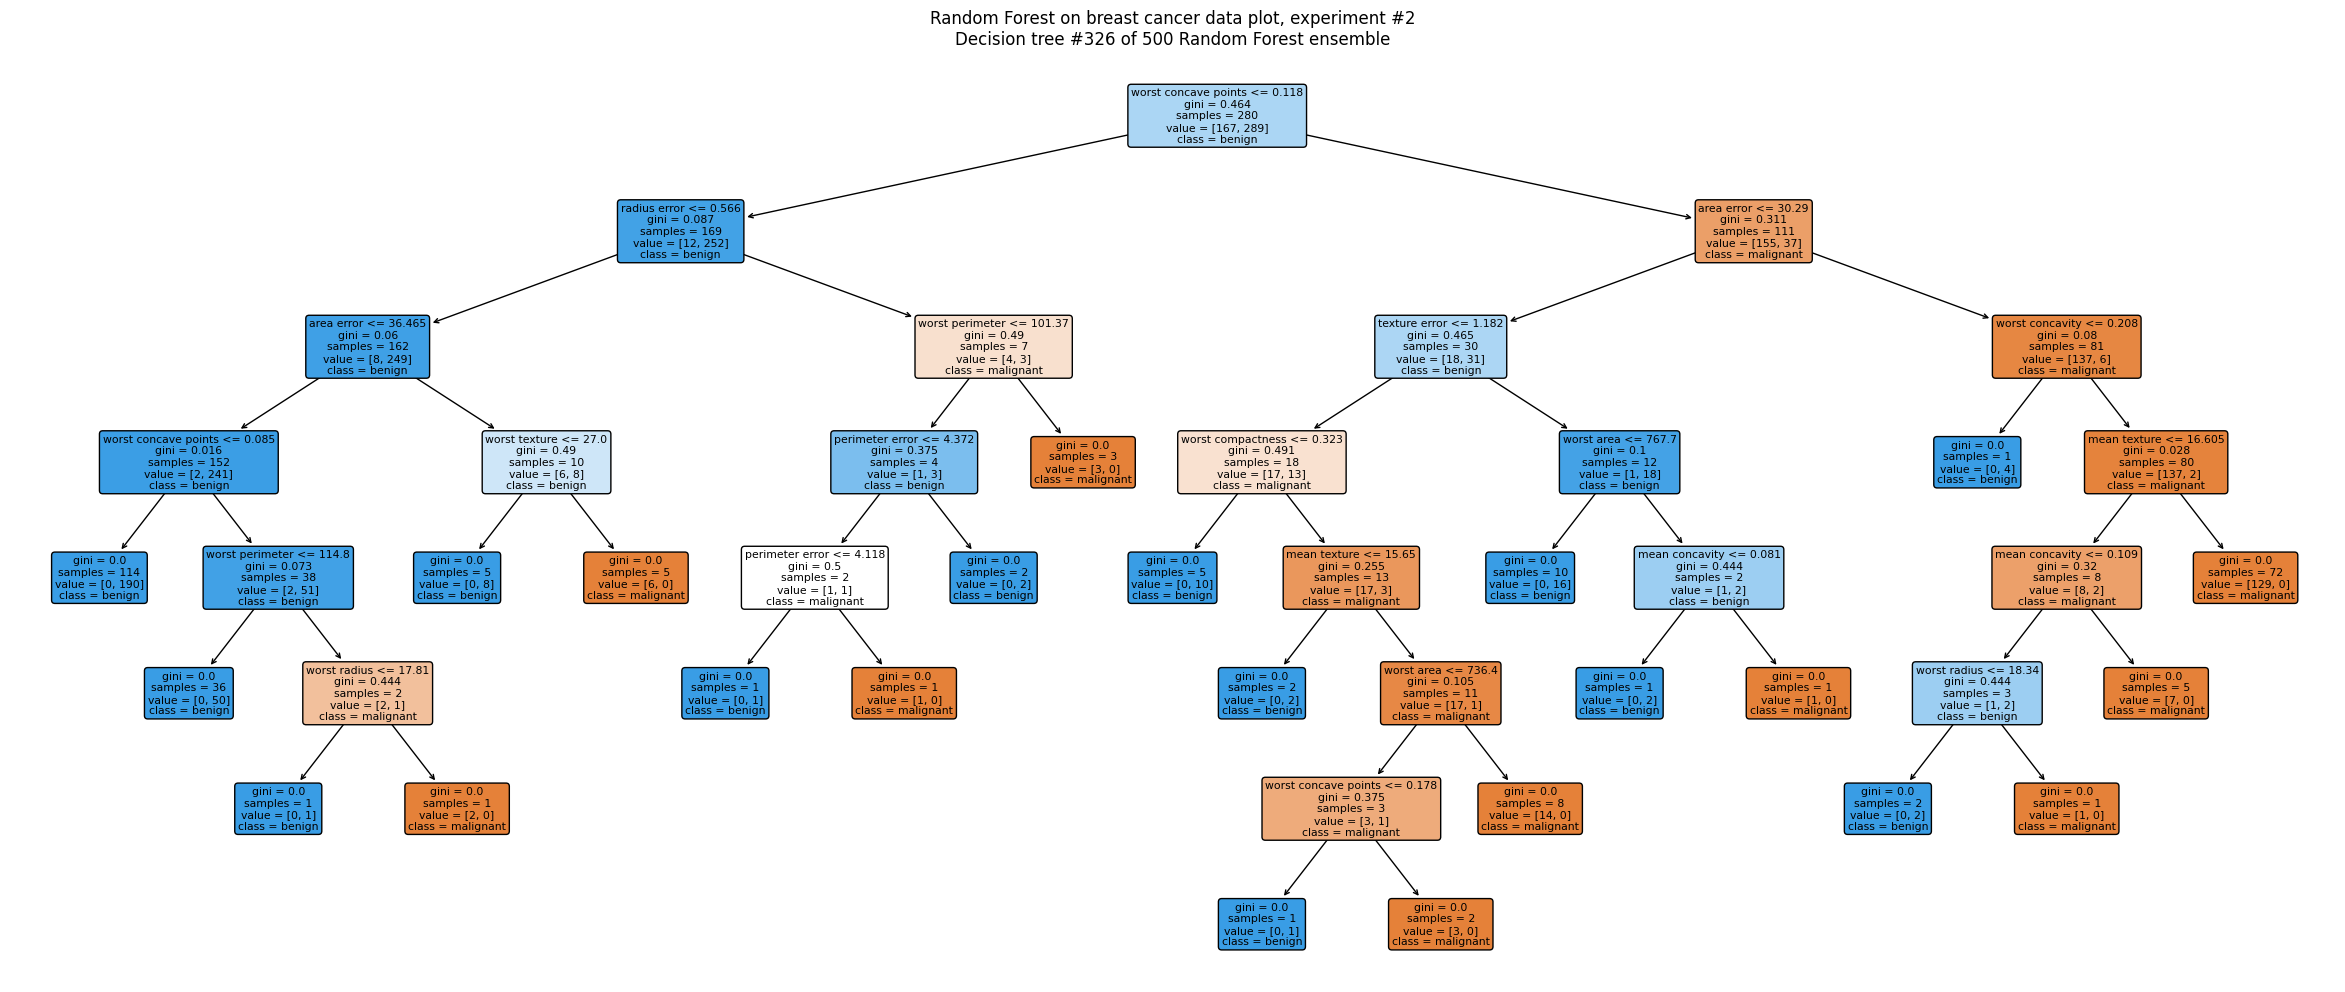

In [ ]:
evaluator.plot_single_rf_tree()

##Experiment #3 Multi Layer Perceptron

In [ ]:
# set LOCAL variables per experiment
experiment_num = '3'
model_desc = 'MLP'
classifier = MLP(random_state=8, max_iter=300)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [ ]:
evaluator.print_classification_report()

MLP on breast cancer data experiment #3:

              precision    recall  f1-score   support

      benign       0.97      0.97      0.97        71
   malignant       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



###Confusion matrix

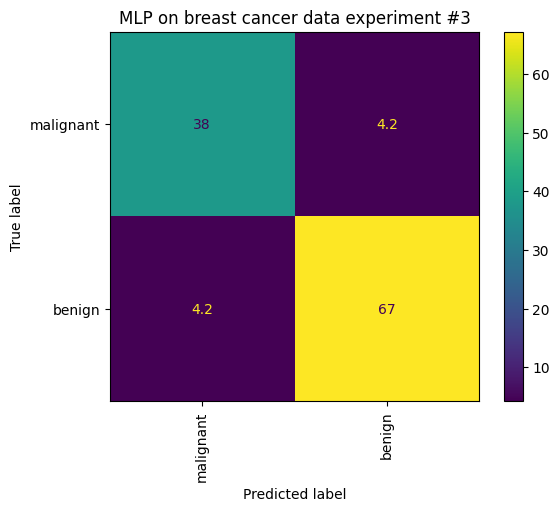

In [ ]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

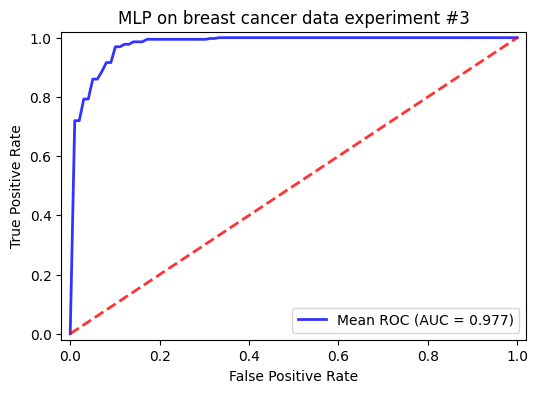

In [ ]:
evaluator.plot_roc_curve()

#Explain + interpret

##XAI global

####SHAP (**SH**apley **A**dditive ex**P**lanations)
Explanation of SHAP and game theory
Expolanation of XGBoost
* [Medium: XGBoost Explained: A Beginner’s Guide](https://medium.com/low-code-for-advanced-data-science/xgboost-explained-a-beginners-guide-095464ad418f)
* https://github.com/shap/shap?tab=readme-ov-file#sample-notebooks
* https://shap.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
* [Github repo](https://github.com/shap/shap)

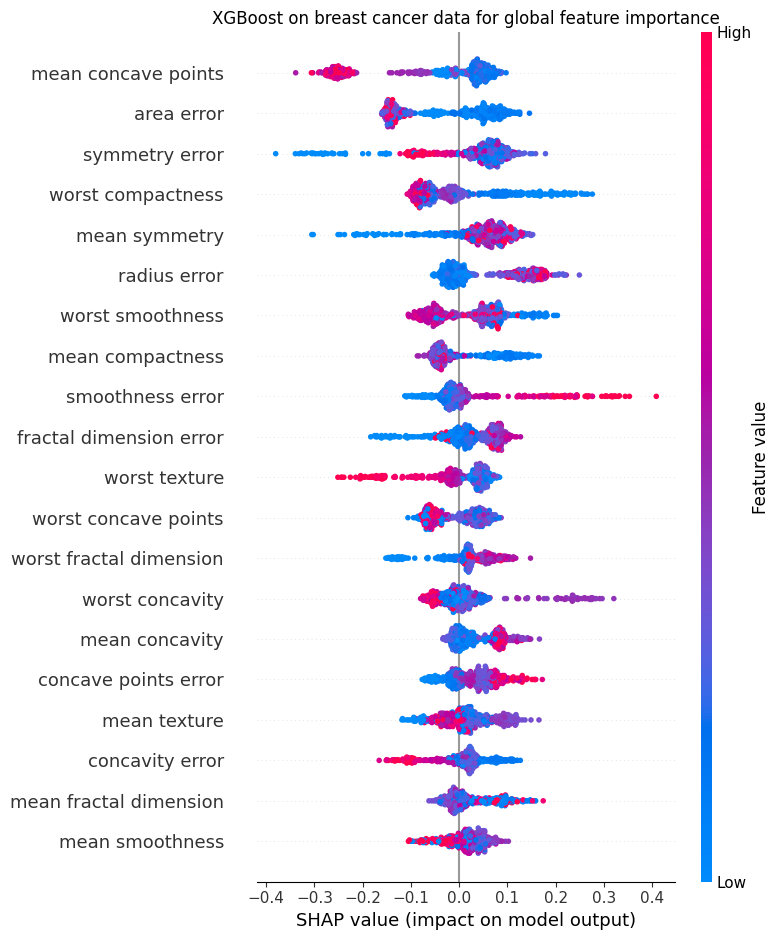

In [ ]:
# run class and functions using global and local vars
evaluator.print_shap_for_global_explanation()

##XAI local

In [ ]:
# using last initialised classsifier
evaluator.print_lime_for_local_explanation()

Observation #472, from a total of 114 breast cancer data, for local feature importance:
Intercept 0.5054719246305247
Prediction_local [0.47941371]
Right: 0.620814274980416


####LIME (**L**ocal **I**nterpretable **M**odel-Agnostic **E**xplanations)
* [LIME documentation](https://lime-ml.readthedocs.io/en/latest/index.html)
* **Intercept**: is the base prediction of the linear model that LIME fits locally around the instance. In other words, it is the predicted probability for the instance before considering the effects of any features. This value represents the starting point (or bias) in the linear approximation model. LIME creates a simple linear model that approximates the complex classifier’s behavior in the neighborhood of the instance being explained. The intercept is the value when all feature effects are set to zero.
* **Prediction local**: is the probability predicted by the linear model (the surrogate model) that LIME has generated for this specific instance.
In this case, the LIME model predicts a probability of 0.61973125 for the positive class (or the class of interest).
This value results from adding the contributions of the features to the intercept.
* **Right**: refers to the actual probability predicted by your original classifier (the one you trained) for the instance being explained.
In this case, your classifier predicts a probability of 0.9936492970816642 for the positive class.
This indicates that the classifier is very confident about its prediction for this instance.

#Counterfactuals + advice

In [ ]:
# FIRST STEP FOR COUNTERFACTUALS IS VIEWING A LIST OF DESIRABLE AND NON-DESIRABLE OUTCOMES
# select a non-desirable outcome (using some type of ID), and subsequent row index
# undertand the mutable and unmutable variables



In [ ]:
!pip install pandas --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.2 which is incompatible.


In [ ]:
import pandas as pd
print(pd.__version__)

2.1.4


In [ ]:
!pip -q install dice-ml

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
# EXAMPLE 1 USING ALL CONTINUOUS FEATURES

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import dice_ml
from dice_ml.utils import helpers

# Load the breast cancer dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

x = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # add target name

# Instantiate the model, 80/20 train/test split, fit model
classifier = RandomForestClassifier(random_state=8, n_estimators=500)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8)
classifier.fit(x_train, y_train)

# Update the continuous features and target variable for DiCE
continuous_features = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension',
    'radius error', 'texture error', 'perimeter error', 'area error',
    'smoothness error', 'compactness error', 'concavity error',
    'concave points error', 'symmetry error', 'fractal dimension error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area',
    'worst smoothness', 'worst compactness', 'worst concavity',
    'worst concave points', 'worst symmetry', 'worst fractal dimension'
]


df = pd.concat([x, y], axis=1)                                                  # specify data and model for DiCE, pass the entire dataframe with the target variable

data_dice = dice_ml.Data(dataframe=df,                                          # pass entire dataframe with target variable
                         continuous_features=continuous_features,               # continuous mutable features
                         outcome_name='target')                                 # target variable name

model_dice = dice_ml.Model(model=classifier,
                           backend="sklearn")

dice = dice_ml.Dice(data_dice, model_dice)                                      # generate counterfactuals for a particular instance

query_instance = x_test.iloc[0].to_frame().T # MAKE THIS A RANDOM OBS                                    # select a query instance from the test set, convert the instance into a DataFrame

counterfactuals = dice.generate_counterfactuals(query_instance,
                                                total_CFs=5,
                                                desired_class="opposite")       # generate counterfactuals

counterfactuals.visualize_as_dataframe()

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Query instance (original outcome : 1)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,12.67,17.299999,81.25,489.899994,0.1028,0.07664,0.03193,0.02107,0.1707,0.05984,...,21.1,88.699997,574.400024,0.1384,0.1212,0.102,0.05602,0.2688,0.06888,1



Diverse Counterfactual set (new outcome: 0)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,12.67,17.30,81.25,1528.7,0.1028,0.07664,0.03193,0.02107,0.1707,0.05984,...,21.10,217.9,1417.5,0.1384,0.1212,0.102,0.05602,0.2688,0.06888,0
1,12.67,35.35,81.25,489.9,0.1028,0.07664,0.03193,0.02107,0.1707,0.05984,...,46.86,219.3,3734.7,0.1384,0.1212,0.102,0.05602,0.2688,0.06888,0
2,12.67,17.30,81.25,1723.8,0.1028,0.07664,0.03193,0.02107,0.1707,0.05984,...,21.10,207.3,3369.6,0.1384,0.7659,0.102,0.05602,0.2184,0.06888,0
3,12.67,17.30,81.25,489.9,0.1028,0.07664,0.03193,0.02107,0.1707,0.05984,...,47.30,249.9,2628.1,0.1384,0.1212,0.500,0.20000,0.2688,0.06888,0
4,16.85,17.30,81.25,489.9,0.1028,0.17280,0.03193,0.02107,0.1707,0.05984,...,21.10,205.4,3756.6,0.1384,0.1212,0.102,0.20000,0.2688,0.06888,0


##Unseen data

In [ ]:
# FRAMEWORK REPRESENTS A NEW OBSERVATION (COMMERCIAL DATA)

mutable_features = [         # mutable features to move class to desired outcome
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension'
]

immutable_features = [       # immutable features to remian with original values
    'radius error', 'texture error', 'perimeter error', 'area error',
    'smoothness error', 'compactness error', 'concavity error',
    'concave points error', 'symmetry error', 'fractal dimension error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area',
    'worst smoothness', 'worst compactness', 'worst concavity',
    'worst concave points', 'worst symmetry', 'worst fractal dimension'
]

min_max_data = []             # inititlize list to store min/max values of mutable features

for col in mutable_features:  # loop through features
  min_val = df[col].min()     # extract min value data
  mean_val = df[col].mean()   # extract mean value data
  max_val = df[col].max()     # extract max value data

  min_max_data.append({       # append data to list
      'feature_name': col,    # feature name as list
      'min_val': min_val,     # min value as list
      'mean_val': mean_val,   # mean value as list
      'max_val': max_val      # max value as list
  })

  min_max_df = pd.DataFrame(min_max_data) # convert list to dataframe

min_max_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   feature_name  10 non-null     object 
 1   min_val       10 non-null     float64
 2   mean_val      10 non-null     float64
 3   max_val       10 non-null     float64
dtypes: float64(3), object(1)
memory usage: 448.0+ bytes


In [ ]:
min_max_df # mutable values

,feature_name,min_val,mean_val,max_val
0,mean radius,6.98100,14.127292,28.11000
1,mean texture,9.71000,19.289649,39.28000
2,mean perimeter,43.79000,91.969033,188.50000
3,mean area,143.50000,654.889104,2501.00000
4,mean smoothness,0.05263,0.096360,0.16340
5,mean compactness,0.01938,0.104341,0.34540
6,mean concavity,0.00000,0.088799,0.42680
7,mean concave points,0.00000,0.048919,0.20120
8,mean symmetry,0.10600,0.181162,0.30400
9,mean fractal dimension,0.04996,0.062798,0.09744


In [ ]:
# 'NEW OBSERVATION' REPLICATES MUTABLE FINANCIAL FEATURES
import numpy as np

new_obs_mutable = {}                                      # empty dictionary to store a 'NEW random observation

for idx, row in min_max_df.iterrows():                    # iterate over DF rows and generate a random value for each feature
    feature_name = row['feature_name']
    min_val = row['min_val']
    max_val = row['max_val']
    random_value = np.random.uniform(min_val, max_val)    # generate random value between min_val and max_val
    new_obs_mutable[feature_name] = random_value          # add random value to dictionary with feature name as key
new_obs_mutable = pd.DataFrame([mutable_features])        # convert dictionary into a DF or series

new_obs_mutable = to_frame().T
new_obs_mutable

NameError: name 'to_frame' is not defined

In [ ]:
# REPLICATES A NEW UNSEEN OBSERVATION WITH MUTABLE AND IMMUTABLE VARIABLES

# join a "new observation" with "immutable features". select one original immutable observation
new_observation = pd.concat([new_obs_mutable, new_obs_immutable], axis=1)

new_observation